## Industry Distribution (The "Who" is attending?)
Before planning future events, we need to know which industries our attendees come from. We'll use a Countplot from Seaborn.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

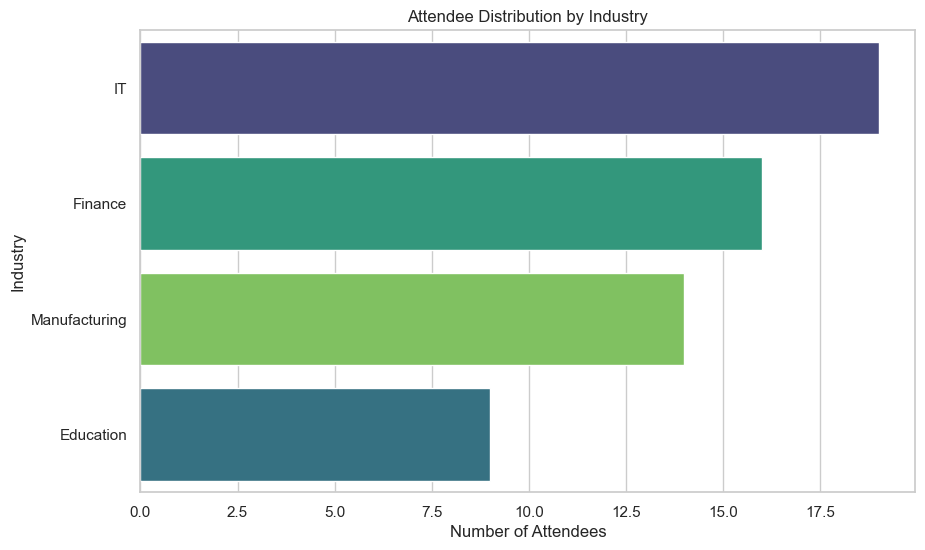

In [7]:
with open(r'C:\Users\VishwasKSingh\Workspace\temp\my_app_practice\data\attendees.json') as f:
    attendees = pd.DataFrame(json.load(f))

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Sort by count for a cleaner look
order = attendees['industry'].value_counts().index
sns.countplot(data=attendees, y='industry', order=order, hue='industry', palette='viridis')

plt.title('Attendee Distribution by Industry')
plt.xlabel('Number of Attendees')
plt.ylabel('Industry')
plt.show()

## Marketing Efficiency (The "How" do they find us?)
We want to see the relationship between Marketing Spend and Impressions across different channels (Email, Social, Partner). A Scatter Plot is used for this.

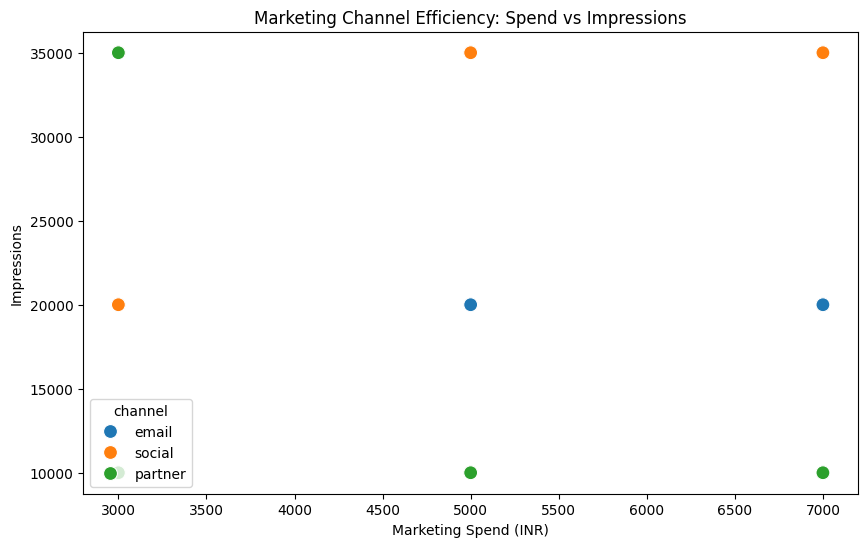

In [3]:
channels = pd.read_csv(r'C:\Users\VishwasKSingh\Workspace\temp\my_app_practice\data\channels.csv')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=channels, x='spend', y='impressions', hue='channel', s=100)

plt.title('Marketing Channel Efficiency: Spend vs Impressions')
plt.xlabel('Marketing Spend (INR)')
plt.ylabel('Impressions')
plt.show()

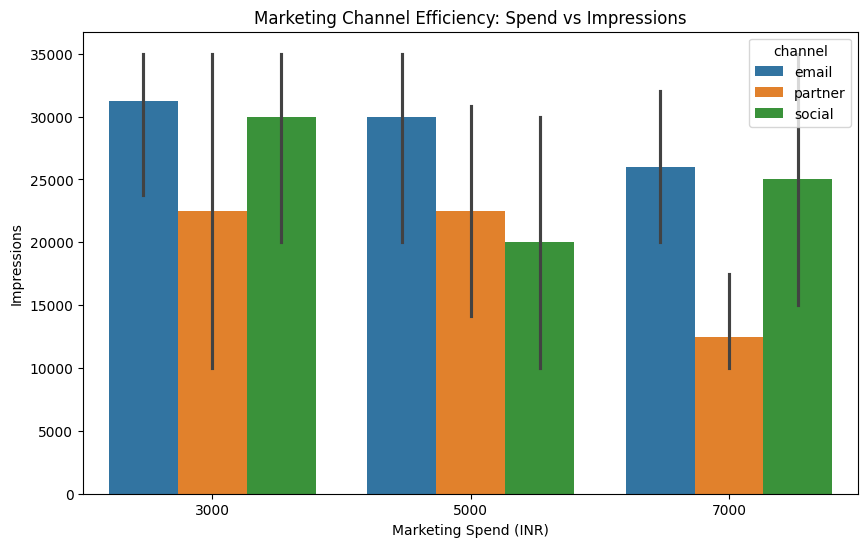

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=channels, x='spend',y='impressions', hue='channel')

plt.title('Marketing Channel Efficiency: Spend vs Impressions')
plt.xlabel('Marketing Spend (INR)')
plt.ylabel('Impressions')
plt.show()

## Capacity Utilization (The "Business" Health)
1. Count paid registrations per event_id.
2. Merge that with events.csv to get the venue_capacity.
3. Calculate the Utilization % and plot it.

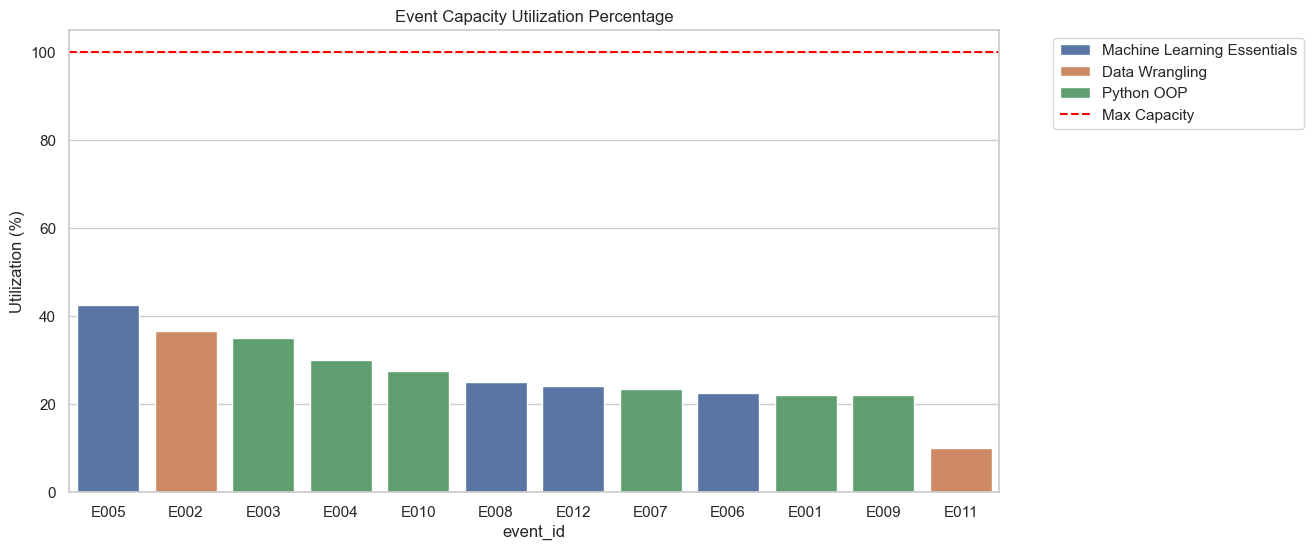

In [9]:
registrations = pd.read_csv(r'C:\Users\VishwasKSingh\Workspace\temp\my_app_practice\data\registrations.csv')
events = pd.read_csv(r'C:\Users\VishwasKSingh\Workspace\temp\my_app_practice\data\events.csv')
# 1. Count paid registrations
reg_counts = registrations[registrations['payment_status'] == 'paid'].groupby('event_id').size().reset_index(name='actual_paid')

# 2. Merge with events data
utilization_df = events.merge(reg_counts, on='event_id', how='left').fillna(0)

# 3. Calculate %
utilization_df['utilization_pct'] = (utilization_df['actual_paid'] / utilization_df['venue_capacity']) * 100

# 4. Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=utilization_df.sort_values('utilization_pct', ascending=False), 
            x='event_id', y='utilization_pct', hue='topic', dodge=False)

plt.axhline(100, color='red', linestyle='--', label='Max Capacity') # Threshold line
plt.title('Event Capacity Utilization Percentage')
plt.ylabel('Utilization (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## Correlation Analysis for Business Strategy
Quantify the impact of different marketing promotions on user behavior using a correlation heatmap.

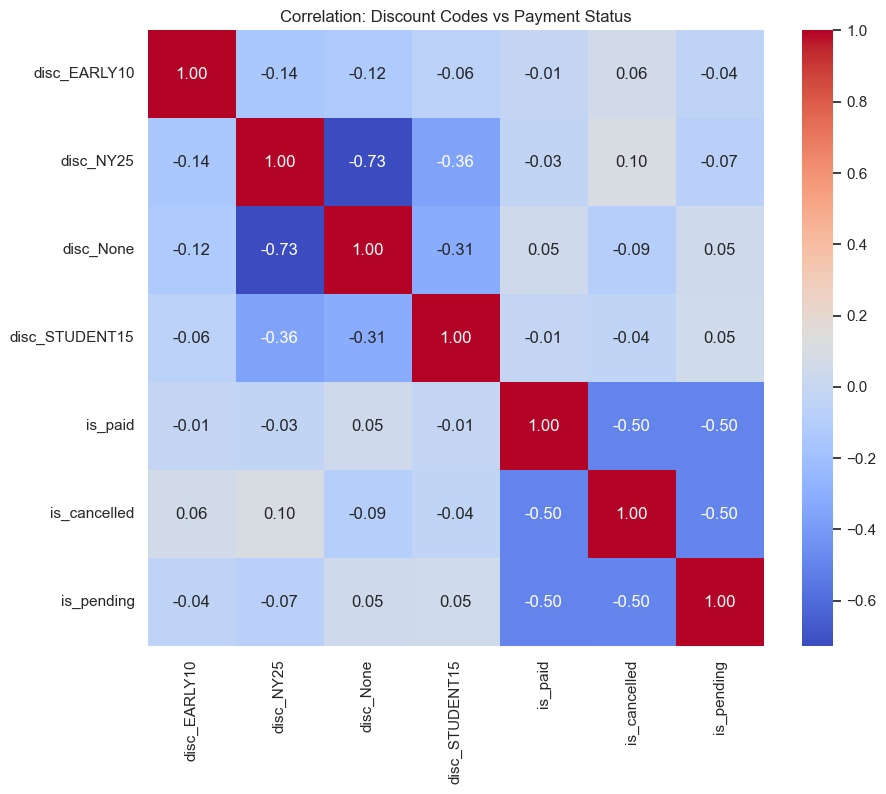

Correlation Matrix:
                 is_paid  is_cancelled  is_pending
disc_EARLY10   -0.012304      0.055444   -0.043175
disc_NY25      -0.031231      0.099359   -0.068141
disc_None       0.045007     -0.091932    0.046851
disc_STUDENT15 -0.013143     -0.038932    0.052216
is_paid         1.000000     -0.503562   -0.500870
is_cancelled   -0.503562      1.000000   -0.495557
is_pending     -0.500870     -0.495557    1.000000


In [10]:
pricing = pd.read_csv(r'C:\Users\VishwasKSingh\Workspace\temp\my_app_practice\data\pricing.csv')
registrations = pd.read_csv(r'C:\Users\VishwasKSingh\Workspace\temp\my_app_practice\data\registrations.csv')

# Merge
df = registrations.merge(pricing, on='event_id')

# Define discount application logic
def get_applied_discount(row):
    code = str(row['discount_code'])
    t_type = row['ticket_type']
    
    if 'STUDENT' in code and t_type == 'student':
        return 'STUDENT15'
    elif 'EARLY' in code and t_type == 'earlybird':
        return 'EARLY10'
    elif 'NY' in code:
        return 'NY25'
    return 'None'

df['applied_discount'] = df.apply(get_applied_discount, axis=1)

# Prepare binary columns for correlation
# We want to see correlation between specific discounts and payment outcomes
analysis_df = pd.get_dummies(df['applied_discount'], prefix='disc')
analysis_df['is_paid'] = (df['payment_status'] == 'paid').astype(int)
analysis_df['is_cancelled'] = (df['payment_status'] == 'cancelled').astype(int)
analysis_df['is_pending'] = (df['payment_status'] == 'pending').astype(int)

# Calculate Correlation Matrix
corr_matrix = analysis_df.corr()

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation: Discount Codes vs Payment Status')
plt.show()

print("Correlation Matrix:")
print(corr_matrix[['is_paid', 'is_cancelled', 'is_pending']])

No Discount (disc_None): This has a positive correlation with is_paid (0.05) and a negative correlation with is_cancelled (-0.09). This statistically confirms that users paying full price are more committed and less likely to drop out.

The New Year Discount (disc_NY25): This is the "worst" performer. It has the strongest correlation with cancellations (0.10). This suggests that high-percentage discounts (25%) might attract "low-intent" users who register on a whim but don't follow through.

Student Discount (disc_STUDENT15): This code is most strongly associated with pending status (0.05). This makes sense for a student demographic that might need more time to arrange payment or are "shopping around."

Early Bird (disc_EARLY10): Similar to the NY discount, this also shows a positive lean toward cancellations (0.06), refuting the idea that it effectively "locks in" early commitment in this dataset.